# Amit Hulandageri

In [2]:
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

In [3]:
from scipy.spatial import distance
import time
from matplotlib import pyplot as plt

In [4]:
from pyspark.sql.functions import isnan, when, count, col

# LSH Class

In [5]:
class LSH:
    
    def __init__(self, filename, k, L):
        """
        Initializes the LSH object
        A - dataframe to be searched
        k - number of thresholds in each function
        L - number of functions
        """
        # do not edit this function!
        conf = SparkConf()
        self.sc = SparkContext().getOrCreate(conf = conf)
        self.k = k
        self.L = L
        self.A = self.load_data(filename)
        self.functions = self.create_functions()
        self.hashed_A = self.hash_data()
        #self.functions_1 = self.cust_func()
        
    def __del__(self):
        self.sc.stop()
        
    def l1(self, u, v):
        """
        Finds the L1 distance between two vectors
        u and v are 1-dimensional Row objects
        """
        l = np.linalg.norm((u - v), ord=1)
        
        return l

    def load_data(self, filename):
        """
        Loads the data into a spark DataFrame, where each row corresponds to
        an image patch -- this step is sort of slow.
        Each row in the data is an image, and there are 400 columns.
        """
        
        b = self.sc.textFile(filename)
        
        return b

    def create_function(self, dimensions, thresholds):
        """
        Creates a hash function from a list of dimensions and thresholds.
        """
        def f(v):
            func = np.array2string(np.where(v[dimensions] >= thresholds, 1, 0))[1:-1]
            return func
    
        return f

    def create_functions(self, num_dimensions=400, min_threshold=0, max_threshold=255):
        """
        Creates the LSH functions (functions that compute L K-bit hash keys).
        Each function selects k dimensions (i.e. column indices of the image matrix)
        at random, and then chooses a random threshold for each dimension, between 0 and
        255.  For any image, if its value on a given dimension is greater than or equal to
        the randomly chosen threshold, we set that bit to 1.  Each hash function returns
        a length-k bit string of the form "0101010001101001...", and the L hash functions 
        will produce L such bit strings for each image.
        """
        functions = []
        for i in range(self.L):
            dimensions = np.random.randint(low = 0, 
                                    high = num_dimensions,
                                    size = self.k)
            thresholds = np.random.randint(low = min_threshold, 
                                    high = max_threshold + 1, 
                                    size = self.k)

            functions.append(self.create_function(dimensions, thresholds))     ###
            
        return functions
    
    
    def hash_vector(self, v):
        """
        Hashes an individual vector (i.e. image).  This produces an array with L
        entries, where each entry is a string of k bits.
        """
        functions = self.create_functions()

        hashed_v = v.map(lambda w : [x.strip() for x in w[0].split(',')])
        hashed_v = hashed_v.map(lambda w : [int(float(c)) for c in w])
        hashed_v = hashed_v.map(lambda w : (w, [f(np.array(w)) for f in functions]))
        
        return hashed_v


    def hash_data(self):
        """
        Hashes the data in A, where each row is a datapoint, using the L
        functions in 'self.functions'
        """
        functions = self.create_functions()        
        
        data = self.A.map(lambda w : [x.strip() for x in w.split(',')])
        data = data.map(lambda w : [int(float(c)) for c in w])
        dataWithIndex = data.zipWithIndex()

        hashed_A = dataWithIndex.map(lambda w : [w[1],w[0], [f(np.array(w[0])) for f in functions]])
                         
        return hashed_A


    def get_candidates(self,hashed_point, query_index):
        """
        Retrieve all of the points that hash to one of the same buckets 
        as the query point.  Do not do any random sampling (unlike what the first
        part of this problem prescribes).
        Don't retrieve a point if it is the same point as the query point.
        """
        
        candidates = self.hashed_A.filter(lambda w : np.any(np.array(w[2]) == np.array(hashed_point[2])))

        #print("Number of candidates :",candidates.count())
        
        return candidates
        

    def lsh_search(self, query_hashed_point, query_index, num_neighbors):
        """
        Run the entire LSH algorithm
        """
        def l1(u, v):
            l = np.linalg.norm((u - v), ord=1)
            return l
        
        #start = time.time()
        candidates = self.get_candidates(query_hashed_point, query_index)
        #print(time.time() - start)

        #start = time.time()
        candidates_dist = candidates.map(lambda w : ( l1( np.array(w[1]), np.array(query_hashed_point[1])),w[0] ))
        #print(time.time() - start)
        
        #start = time.time()
        sorted_cand_dist = candidates_dist.sortByKey()
        #print(time.time() - start)
        
        return sorted_cand_dist.take(num_neighbors+1)[1:(num_neighbors+1)]
    

# Plotting images

In [6]:
# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Nearest neighbours

In [7]:
# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
    
    query_point = np.array([A[query_index,:]])
    
    distances = distance.cdist(A, query_point, 'cityblock')

    
    dist_and_index = [(distances[i],i) for i in range(len(distances))]
    
    dist_and_index = sorted(dist_and_index, key=lambda x: x[0])
    
    return dist_and_index[1:num_neighbors+1]

# Error Measure

In [8]:
# Write a function that computes the error measure
def lsh_error(lsh_sums, linear_sums):
    error = 0
    for i in range(len(lsh_sums)):
        error = error + (lsh_sums[i] / linear_sums[i])
    error = error / len(lsh_sums)
    return error

In [9]:
if __name__ == '__main__':
    #unittest.main(argv=[''], exit=False)
    #unittest.main() ### TODO: Uncomment this to run tests
    
    data_np = np.genfromtxt ('patches.csv', delimiter=",")
    
    # function of L
    k = 24
    L = [10,12,14,16,18,20]
    l_error = []
    for l in L:
        lsh = LSH(filename ='patches.csv',k=k, L=l)

        lsh_nearest_sums = []
        linear_nearest_sums = []

        no_of_queries = 10

        lsh_time = []
        linear_time = []

        for i in range(1,no_of_queries+1):

            # lsh search
            query_index = i*100-1
            query_hashed_point = lsh.hashed_A.collect()[query_index]

            start = time.time()
            lsh_nearest_3 = lsh.lsh_search(query_hashed_point, query_index, 10)
            lsh_time.append(time.time() - start)

            lsh_nearest_3_dist = [point[0] for point in lsh_nearest_3]
            lsh_row_nums = [point[1] for point in lsh_nearest_3]

            lsh_nearest_sums.append(sum(lsh_nearest_3_dist))

            # linear search
            start = time.time()
            linear_nearest_3 = linear_search(data_np, query_index = i*100-1, num_neighbors = 10)
            linear_time.append(time.time() - start)

            linear_nearest_3_dist = [point[0] for point in linear_nearest_3]
            linear_row_nums = [point[1] for point in linear_nearest_3]

            linear_nearest_sums.append(sum(linear_nearest_3_dist))
            
            # Spark linear search
            start = time.time()
            spark_linear_nearest_3 = lsh.spark_lin_search(query_hashed_point, query_index, 3)
            spark_linear_time.append(time.time() - start)

            spark_linear_nearest_3_dist = [point[0] for point in spark_linear_nearest_3]
            spark_linear_row_nums = [point[1] for point in spark_linear_nearest_3]

            spark_linear_nearest_sums.append(sum(spark_linear_nearest_3_dist))

        print("Time taken for LSH : ",lsh_time)
        print("Average time for LSH search : ",sum(lsh_time)/len(lsh_time))
        print("Time taken for Linear search : ",linear_time)
        print("Average time for linear search : ",sum(linear_time)/len(linear_time))
        print("Time taken for Spark Linear search : ",spark_linear_time)
        print("Average time for Spark linear search : ",sum(spark_linear_time)/len(spark_linear_time))

        error_1 = lsh_error(lsh_nearest_sums, linear_nearest_sums)
    
        error_2 = lsh_error(lsh_nearest_sums, spark_linear_nearest_sums)
        
        l_error.append(error_2)
        print("Error for l value ",l ," : ",error_2)

        lsh.sc.stop()
        
    
    # function of k    
    L = 10
    K = [16,18,20,22,24]
    k_error = []
    for k in K:
        lsh = LSH(filename ='patches.csv',k=k, L=L)

        lsh_nearest_sums = []
        linear_nearest_sums = []

        no_of_queries = 10

        lsh_time = []
        linear_time = []

        for i in range(1,no_of_queries+1):

            # lsh search
            query_index = i*100-1
            query_hashed_point = lsh.hashed_A.collect()[query_index]

            start = time.time()
            lsh_nearest_3 = lsh.lsh_search(query_hashed_point, query_index, 10)
            lsh_time.append(time.time() - start)

            lsh_nearest_3_dist = [point[0] for point in lsh_nearest_3]
            lsh_row_nums = [point[1] for point in lsh_nearest_3]

            lsh_nearest_sums.append(sum(lsh_nearest_3_dist))

            # linear search
            start = time.time()
            linear_nearest_3 = linear_search(data_np, query_index = i*100-1, num_neighbors = 10)
            linear_time.append(time.time() - start)

            linear_nearest_3_dist = [point[0] for point in linear_nearest_3]
            linear_row_nums = [point[1] for point in linear_nearest_3]

            linear_nearest_sums.append(sum(linear_nearest_3_dist))
            
            # Spark linear search
            start = time.time()
            spark_linear_nearest_3 = lsh.spark_lin_search(query_hashed_point, query_index, 3)
            spark_linear_time.append(time.time() - start)

            spark_linear_nearest_3_dist = [point[0] for point in spark_linear_nearest_3]
            spark_linear_row_nums = [point[1] for point in spark_linear_nearest_3]

            spark_linear_nearest_sums.append(sum(spark_linear_nearest_3_dist))

        print("Time taken for LSH : ",lsh_time)
        print("Average time for LSH search : ",sum(lsh_time)/len(lsh_time))
        print("Time taken for Linear search : ",linear_time)
        print("Average time for linear search : ",sum(linear_time)/len(linear_time))
        print("Time taken for Spark Linear search : ",spark_linear_time)
        print("Average time for Spark linear search : ",sum(spark_linear_time)/len(spark_linear_time))

        error_1 = lsh_error(lsh_nearest_sums, linear_nearest_sums)
    
        error_2 = lsh_error(lsh_nearest_sums, spark_linear_nearest_sums)
        
        k_error.append(error_2)
        print("Error for k value ",k ," : ", error_2)

        lsh.sc.stop()

Error for l value  10  :  [1.11539303]
Error for l value  12  :  [1.0223491]
Error for l value  14  :  [1.09855784]
Error for l value  16  :  [1.07324563]
Error for l value  18  :  [1.08695998]
Error for l value  20  :  [1.063757]
Error for k value  16  :  [1.06022878]
Error for k value  18  :  [1.05306285]
Error for k value  20  :  [1.0555756]
Error for k value  22  :  [1.06511041]
Error for k value  24  :  [0.99414075]


In [ ]:
# Plotting graphs

Text(0, 0.5, 'error')

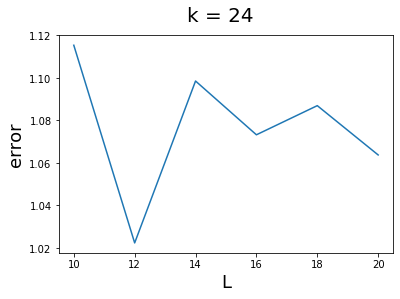

In [19]:
fig = plt.figure()
plt.plot([10,12,14,16,18,20],l_error)
fig.suptitle('k = 24', fontsize=20)
plt.xlabel('L',fontsize=18)
plt.ylabel('error',fontsize=18)

Text(0, 0.5, 'error')

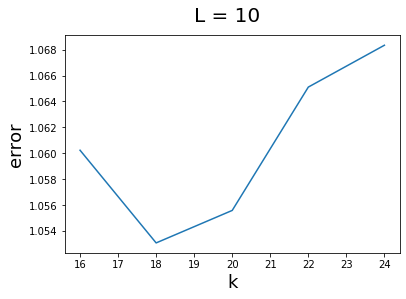

In [18]:
fig = plt.figure()
plt.plot([16,18,20,22,24],k_error)
fig.suptitle('L = 10', fontsize=20)
plt.xlabel('k',fontsize=18)
plt.ylabel('error',fontsize=18)